In [1]:
#Import needed packages

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_curve
from sklearn import metrics

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
#load preprocessed data
mrna_x = pd.read_csv('zscore_mutation_methlyation.csv')
mrna_x.drop(columns=mrna_x.columns[0], axis=1, inplace=True)
y = np.load('processed_mrna_data_zscore_mutation_methlyation.npy')

print(mrna_x.shape)
X_train, X_test, y_train, y_test = train_test_split(mrna_x.values, y,
                                                    train_size=0.75, test_size=0.25)

age = np.load('age_data_mutation_methylation.npy')
gender = np.load('gender_data_mutation_methlyation.npy')
stage = np.load('stage_data_mutation_methylation.npy')




(210, 47751)


In [3]:
mrna_x.head()

,LOC100130426,UBE2Q2P3,UBE2Q2P3.1,TIMM23,LOC155060,RNU12-2P,SSX9,EZHIP,EFCAB8,SRP14P1,...,SND1 Methylation,LOC100124692 Methylation,MCM4 Methylation,FBXO25 Methylation,WHSC1L1 Methylation,HNRNPK Methylation,KIAA1432 Methylation,AUH Methylation,RABGAP1 Methylation,MAPKAP1 Methylation
0,-3.0863,1.6955,-0.2368,0.0596,-0.1545,-0.0312,-0.9372,-1.1769,-1.0054,0.0097,...,0.033797,0.019649,0.204339,0.076703,0.182662,0.203466,0.161770,0.071998,0.038556,0.047702
1,-0.6899,0.3369,-1.8035,-0.4247,-0.1294,-1.1709,-0.9372,-0.2185,0.2979,0.3521,...,0.028413,0.033129,0.084335,0.043147,0.107383,0.088992,0.088157,0.056307,0.038288,0.036510
2,-3.0863,1.5766,0.7574,-1.2475,0.4810,0.2606,-0.9372,0.8946,-0.2900,1.2966,...,0.031209,0.019652,0.151872,0.056361,0.108443,0.164716,0.140653,0.065337,0.029315,0.049104
3,-3.0863,1.3656,-0.5168,-1.0347,0.4268,-0.2926,-0.9372,-0.7295,0.8634,-0.4918,...,0.044433,0.044109,0.112851,0.039710,0.094104,0.121972,0.104191,0.053501,0.031203,0.033189
4,-3.0863,0.1986,-0.6028,-0.0509,-0.9082,-1.9249,-0.9372,0.1226,-1.0782,-1.1314,...,0.030863,0.029307,0.139735,0.052231,0.104573,0.136189,0.064693,0.044280,0.024178,0.029658


In [4]:
#LASSO
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
#lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
#lasso_cv.fit(mrna_x.values, y)
#print("Best Params {}".format(lasso_cv.best_params_))

# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001, tol=0.001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

names=mrna_x.columns
print("Column Names: {}".format(names.values))
print(len(names))

feature_subset=np.array(names)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))
print(len(feature_subset))

lasso_x = mrna_x[feature_subset]
print(lasso_x.shape)

lasso_x['Age'] = age
lasso_x['Gender'] = gender
lasso_x['Stage'] = stage


X_train, X_test, y_train, y_test = train_test_split(lasso_x.values, y,
                                                    train_size=0.75, test_size=0.25, shuffle=True, random_state=123)

ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
x = lasso_x.shape[1]

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(x, input_shape=(x,),activation=tf.nn.relu),
  tf.keras.layers.Dense(int(x/2), activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation='sigmoid')

])

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.BinaryCrossentropy()])

In [ ]:
weights = {}
num_samples = len(y_train)
pos_count = sum(y_train)
neg_count =  num_samples - pos_count

weights[0] = num_samples / (2 * neg_count)
weights[1] = num_samples / (2 * pos_count)


print(weights, num_samples, pos_count, neg_count)

{0: 0.7058823529411765, 1: 1.7142857142857142} 192 56 136


In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)

model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), class_weight = weights, callbacks=[es])

#Validate the model

model.evaluate(X_test, y_test, verbose=2)

Epoch 1/100


6/6 [==============================] - 1s 45ms/step - loss: 3.3437 - accuracy: 0.5260 - binary_crossentropy: 2.5411 - val_loss: 2.7766 - val_accuracy: 0.3385 - val_binary_crossentropy: 2.7766
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 1.0801 - accuracy: 0.6094 - binary_crossentropy: 1.2304 - val_loss: 0.7984 - val_accuracy: 0.6769 - val_binary_crossentropy: 0.7984
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4132 - accuracy: 0.8594 - binary_crossentropy: 0.3215 - val_loss: 0.8578 - val_accuracy: 0.5846 - val_binary_crossentropy: 0.8578
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 0.2938 - accuracy: 0.7760 - binary_crossentropy: 0.3941 - val_loss: 0.5713 - val_accuracy: 0.7846 - val_binary_crossentropy: 0.5713
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1956 - accuracy: 0.9479 - binary_crossentropy: 0.1376 - val_loss: 0.6233 - val_accuracy: 0.8000 - val_binary

[0.5713364481925964, 0.7846153974533081, 0.5713364481925964]

In [ ]:
y_prob_tf = model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 1000, max_iter=2000, class_weight=weights, penalty='l1', solver='liblinear', random_state=123)
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))
y_prob_lr = lr.predict_proba(X_test)[:,1]

0.7538461538461538


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 15)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))
y_prob_rf = rf.predict_proba(X_test)[:,1]

0.676923076923077


In [ ]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(num_leaves = 3, verbose=0)
lgb.fit(X_train, y_train)
print(lgb.score(X_test, y_test))
y_prob_lgb = lgb.predict_proba(X_test)[:,1]

0.7230769230769231


In [ ]:
from sklearn.svm import SVC
svc = SVC(probability=True, C=1000, kernel='linear')
svc.fit(X_train, y_train)
print(svc.score(X_test, y_test))
y_prob_svc = svc.predict_proba(X_test)[:,1]

0.8769230769230769


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
print(kn.score(X_test, y_test))
y_prob_kn = kn.predict_proba(X_test)[:,1]



0.676923076923077


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier(random_state=123)
adb.fit(X_train, y_train)
print(adb.score(X_test, y_test))
y_prob_adb = adb.predict_proba(X_test)[:,1]

0.7538461538461538


In [ ]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train, y_train)
print(bnb.score(X_test, y_test))
y_prob_bnb = bnb.predict_proba(X_test)[:,1]


0.7846153846153846


In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=123, learning_rate= 'constant', solver= 'lbfgs', activation = 'logistic', alpha = 0.05)

parameter_space = {
    'activation': ['relu', 'identity', 'logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.001],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

print('Best parameters found:\n', clf.best_params_)


mlp.fit(X_train, y_train)
print(mlp.score(X_test, y_test))
y_prob_mlp = mlp.predict_proba(X_test)[:,1]

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.8461538461538461


c:\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


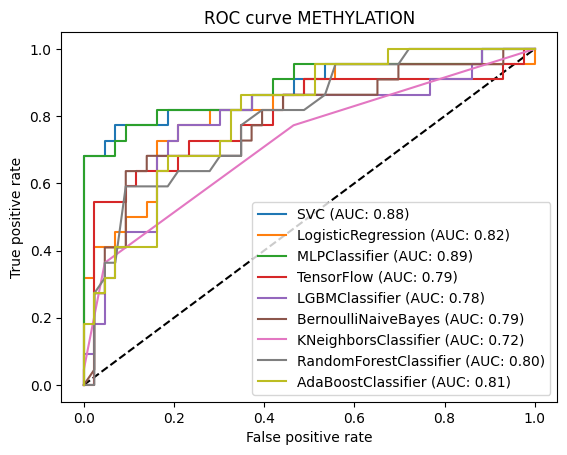

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

fpr, tpr, thresholds = roc_curve(y_test, y_prob_svc)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='SVC (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='LogisticRegression (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_mlp)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='MLPClassifier (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_tf)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='TensorFlow (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_lgb)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='LGBMClassifier (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_bnb)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='BernoulliNaiveBayes (AUC: {:.2f})'.format(auc_val))


fpr, tpr, thresholds = roc_curve(y_test, y_prob_kn)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='KNeighborsClassifier (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='RandomForestClassifier (AUC: {:.2f})'.format(auc_val))



fpr, tpr, thresholds = roc_curve(y_test, y_prob_adb)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='AdaBoostClassifier (AUC: {:.2f})'.format(auc_val))




plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve mRNA + Mutation + Methylation')
plt.legend(loc='best')
plt.show()
